# Project Description
This notebook will demonstrate different machine learning models for classification on non linear data. I will explain what the problem is and what we are trying to do and different techniques and how to do it. In this notebook we have some non linear data where there are two categories that are not linearly separable that we are trying to classify. This notebook will show different classification algorithms (logistic regression, k nearest neighbors, decision trees and random forests) to analyse their performance and see how well they solve the problem. I will explain a little bit about what the model is doing, how they work and their limitations. In the end the notebook will also explain what each result means and if they are any good. Lastly, I will also explain which algorithms worked best to solve this problem. 

This notebook requires some basic understanding of machine learning algorithms. However I will be going over each algorithm and give a simple explanation about how they work. This notebook is also written in python so some basic understanding of python would be helpful but there are also comments of what everything is doing as well. 

# Imports

In [1]:
from matplotlib.colors import ListedColormap # for grgphing decision boundaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Loading Data
The data comes from the other notebook in this directory `make_dataset`. I created the dataset using sklearn and using the make moons function with a little bit of noise (more overlaps in data). The data is then stored in the `data2` folder. Orginally I had a make moons dataset with no noise so using all these algorithms on the data was a bit boring beause everything worked well. That data can be found in `data`. If you are interested in seeing more about how the data was created check out the `make_dataset` notebook. 

In [2]:
# location of the data
! ls data2

X_test.csv  X_train.csv y_test.csv  y_train.csv


In [3]:
data_folder = 'data2'

In [4]:
X_train = pd.read_csv(f'./{data_folder}/X_train.csv')
y_train = pd.read_csv(f'./{data_folder}/y_train.csv')
X_test = pd.read_csv(f'./{data_folder}/X_test.csv')
y_test = pd.read_csv(f'./{data_folder}/y_test.csv')

In [5]:
# here is the X_train data containg our two variables x_1 and x_2
X_train

,x_1,x_2
0,-0.950855,-0.054548
1,1.483296,-0.256707
2,0.600561,0.713502
3,0.380355,0.992979
4,-0.697465,0.479817
...,...,...
1120,0.252528,0.766863
1121,-1.084333,0.366206
1122,1.678493,-0.351117
1123,-0.657989,0.804166


# Graphing the Data
Down here is some code to graph the data. First I had to split the data by category so that there can be a clear visual difference between the category. In the graph there are two clusters one of them in red and the other in blue. There can also be seen that they overlap so the color coding was very helpful. From the graph we can see what data looks like. Clearly this is not linear data and its not linearly seperable. This will be what what we are trying to do which is testing machine learning models for classification on this non linear data. 

Below that graphed data there is also another graphing function (`graph_boundary`). This function will be used later to graph the data as well but with a decison boundary. The decision boundary will be used to see how the model is predicting and see if there is any overfitting going on or if it miss classifies something.

In [6]:
def seperate_categories(df):
    """function to seperate dataframes by category"""
    category_zero = df.loc[df['output'] == 0]
    category_one = df.loc[df['output'] == 1]
    return category_zero, category_one

In [7]:
X_df = pd.DataFrame(data=X_train)
y_df = pd.DataFrame(data=y_train)
dataframes = [X_df, y_df]
result = pd.concat(dataframes, axis=1)
class_one, class_two = seperate_categories(result)

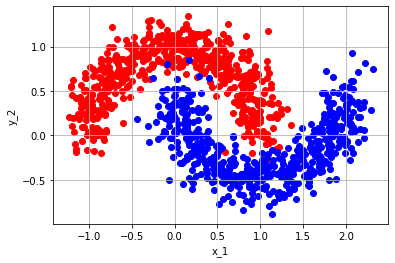

In [8]:
%matplotlib inline 
plt.scatter(class_one['x_1'], class_one['x_2'], color='r')
plt.scatter(class_two['x_1'], class_two['x_2'], color='b')
plt.xlabel('x_1')
plt.ylabel('y_2')
plt.grid(True)
plt.show();

In [9]:
def graph_boundary(model, class_one, class_two):
    # colors for graphing decision boundary
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading="auto")
    # plot the data by categories 
    plt.scatter(class_one['x_1'], class_one['x_2'], color='r')
    plt.scatter(class_two['x_1'], class_two['x_2'], color='b')
    # set the x and y limits of the graph
    plt.xlim([min(X_train['x_1']), max(X_train['x_1'])])
    plt.ylim([min(X_train['x_2']), max(X_train['x_2'])])
    plt.show()

In [10]:
# reformat data to numpy array so we can use it more easily
y_train = y_train['output']

# Using Logistic Regression
- describe what type of algorithm it is (classification)
- describe overview of how it works 
- describe logic of how it works (how is it useful)
- describe training and prediction complexity
- limitations
- todo look up standard way to describe algorithm

In [11]:
# import model
from sklearn.linear_model import LogisticRegression 

In [12]:
# create the model 
logistic_regression = LogisticRegression()

In [13]:
 # train model on the training data
logistic_regression = logistic_regression.fit(X_train, y_train)

Here are the train and the test accuarcy. We can see that the scores are fairly high. Altough the test score is the lowest of these algorithms it is still a very high score. It gets a majority of the examples correctly but we can always get more correct. To understand more about the model and what its doing there is a graph of a confusion matrix and a graph of the decision boundary below. This will help us understand how the model is predicting and how its making its decisions. 

In [14]:
# get train accuracy
f'Training Accuracy: {logistic_regression.score(X_train, y_train)}'

'Training Accuracy: 0.8684444444444445'

In [15]:
# get test accuracy
f'Test Accuracy: {logistic_regression.score(X_test, y_test) }'

'Test Accuracy: 0.9093333333333333'

This is a decision matrix. A decision matrix can also show us more into how our model is working and what its doing. As we can see this validates that our train and test scores are good and that the model is performing well. From this matrix we can tell it performs well because for example if we look at the `true label` axis for the class `0` we see that the predicted label for `zero` (the correct label) is so much higher for `1`. This means that the model predicted the true label correctly `147` times and predicted the false label `14` times. The same can be said for the class `1` aswell.

In [16]:
from sklearn.metrics import plot_confusion_matrix

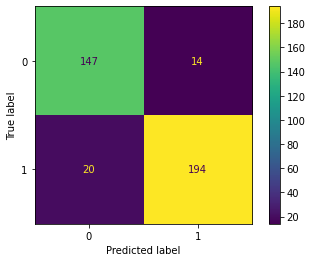

In [17]:
plot_confusion_matrix(logistic_regression, X_test, y_test)  
plt.show() 

Here is a graph of the desicion boundary. The desicion boundary is the boundary that shows how our model is classifying data. For example here is the graph of the desicion boundary for logistic regression for our problem. As we can see there is a line running through both categories/clusters. That line is what the model uses to ceperate and predict categories. Meaning if we want to classify a new example and its in the blue section or below the line it will belong to that class. We can see that the model gets the majority of the data correctly but fails to classify the middle examples.  

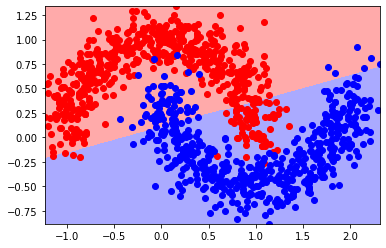

In [18]:
graph_boundary(logistic_regression, class_one, class_two)

# Using KNN
Now we will be using another classification algorithm which is knn (k nearest neighbors). The way this algorithm works is that we want to classify something we find some odd number `k`. This odd number is how many near by examples we will check. For example if our `k=3` we will check for the three closests neighbors of our example we are trying to classify. The majority catergory in those three neighbors is what the algorithm predicts. One thing to note is that we check how close the neighbors are by taking the distance from one example to our example. A common distance is the Euclidean distance where distance equals $ d=\sqrt{(x_2-x_1)^2+(y_2-y_1)^2} $. And $ (x_1,y_1) $ are one point and $ (x_2,y_2) $ is another point. This function takes the distance between those two points. This is how we find what is closest to our example we are trying to classify. Here is a visual example

In [19]:
# import model
# test comment
from sklearn.neighbors import KNeighborsClassifier

A big part of `k nearest neighbors` is the hyperparameter `k`. Here we have our `k` equal to seven. As mentioned earlier this is the number of neighbors the algorithm will check to make a prediction. There are many ways we can choose our `k` one way is just trying manually a bunch of different values and checking what gives us a better outcomes. This of course can work but is not a good solution. Another way is making some desicions on what would be a good value. For example I knew the number needed to be odd and I knew that a if a choose a small odd number like three I could possbily risk overfitting. Here is an example using a number I thought would be a good fit. 

In [20]:
# create model with 7 neighbors to define
manual_knn = KNeighborsClassifier(n_neighbors=7)

In [21]:
# train the model
manual_knn = manual_knn.fit(X_train, y_train)

In [22]:
# get training accuracy
f'Training Accuracy: {manual_knn.fit(X_train, y_train).score(X_train, y_train)}'

'Training Accuracy: 0.992'

In [23]:
# get test accuracy
f'Test Accuracy: {manual_knn.score(X_test, y_test)}'

'Test Accuracy: 0.9946666666666667'

Looking at the confusion matrix for this algorithm we can see that it also performs really well. It performs better than logistic regression. It performs better because as I explained earlier if wee look at the `true label` axis for the class `0` we see that the predicted label for zero (the correct label) is so much higher for class `1`. Its actually perfect it doesn't even predict class `1` at all. Same for the other class. The test score is higher and the matrix shows the algorithm gets the correct label most of the times. From this we know this algorithm works well

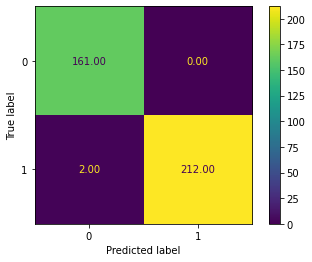

In [24]:
plot_confusion_matrix(manual_knn, X_test, y_test, values_format = '.2f')
plt.show()

The desicion boundary here is very different compared to the logistic regression one. While the logistic regression one was just a straight line through the category the decision boundary for knn circles around both categories seperating them. We can see that it doesn't perfectly classify every example. This can be seen by some blue dots in the red boundary and some red dots in the blue boundary. Of course this is also a good thing because if it perfectly categories everything then that means that there is some overfitting. 

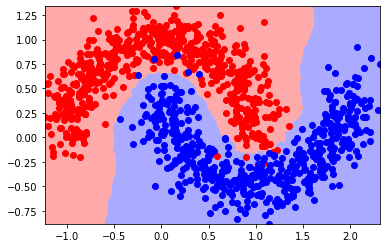

In [25]:
graph_boundary(manual_knn, class_one, class_two)

Another way of getting a hyperparameter is using hyperparameter optimization which is using machine learning to learn which parameters are best for our algorithm. An example of this is [linear regression with graident desecent](https://github.com/GaelGil/notebooks/blob/master/linear_regression/gradient_descent.ipynb). In gradient descent we take the gradient of the sum of the squared errors to find the best parameters for our algorithm. Here is an example of knn using a method of hyper parameter optimization called grid search. 

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
clf = GridSearchCV(KNeighborsClassifier(),{
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}, return_train_score=False)

In [28]:
# warning: this cell takes a long time to run
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]})

In [29]:
df = pd.DataFrame(clf.cv_results_) 

From this dataframe here we can tell that any parameter would be good. Some parameters would give us a slightly better test score but over all they are all good. A reason for all these parameters being good is because if we take a look at the graph and see the data. All the data is fairly close to each other meaning the closest neighbor will always be the correct class. However in the edges where the data overlaps this wont always be true. We can see that some red dots are directly next to the majority blue meaning its closest neighbor is not the category it belongs to.

In [30]:
# TODO: graph this and take argmax
df[['param_n_neighbors', 'mean_test_score']]

,param_n_neighbors,mean_test_score
0,1,0.982222
1,3,0.987556
2,5,0.987556
3,7,0.988444
4,9,0.988444
5,11,0.988444


Here is a graph of the of how the test score changes as our hyper parameter `k` increases. We can see that the higher the value is the better the test score is. The biggest jump is from `k=1` to `k=3`.  After that the score stays the same even if we crease the `k`.

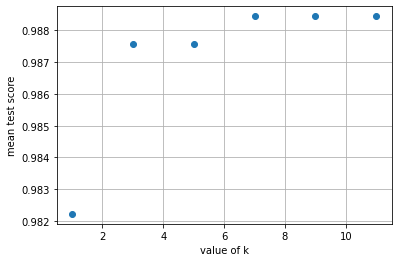

In [31]:
%matplotlib inline 
plt.scatter(df['param_n_neighbors'], df['mean_test_score'])
plt.xlabel('value of k')
plt.ylabel('mean test score')
plt.grid(True)
plt.show();

# Using Desicion Trees
Another great classification algorithm is desicion trees. The way this model works is the model takes in some data. The model then takes each example split them all into binary catergories. It stops until there are no more catergories we can split the examples into. To simplify it the model creates a bunch of if statements that each example has . When we want to classify a new example we just put the example through our tree and it gets fit into one of these statements until it cant go further. 

In [32]:
 # import model
from sklearn import tree

In [33]:
tree_clf = tree.DecisionTreeClassifier()

In [34]:
tree_clf = tree_clf.fit(X_train, y_train)

In [35]:
f'Training Accuracy: {tree_clf.score(X_train, y_train)}'

'Training Accuracy: 1.0'

In [36]:
f'Test Accuracy: {tree_clf.score(X_test, y_test)}'

'Test Accuracy: 0.9893333333333333'

As we can see the desicion boundary here has no curves its just straight lines. This makes sense of course because as I mentioned earlier our algorithm breaks down everything into binary categories meaning it can go one way or the other and theres no in between. From this graph we can also tell that it the model is overfitting. We know this becuase at around `y=-.25` and through `x=0.5` and `x=1.5` there is a thin red line trying to catch the red dots that are in the blue boundary. 

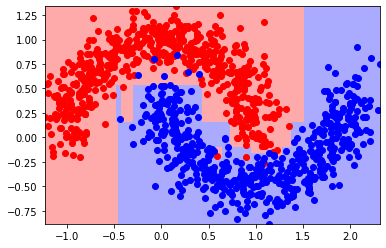

In [37]:
graph_boundary(tree_clf, class_one, class_two)

# Using Random Forests

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
grid_search_random_forest = GridSearchCV(RandomForestClassifier(),{
    'max_depth': [1, 2, 3, 4, 5, 6],
    'random_state': [0, 1]
}, return_train_score=False)

In [58]:
# warning: this cell takes a long time to run
grid_search_random_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'random_state': [0, 1]})

In [59]:
# TODO: graph this and take argmax
grid_search_random_forest_results = pd.DataFrame(grid_search_random_forest.cv_results_)

In [60]:
grid_search_random_forest_results[['param_max_depth', 'param_random_state', 'mean_test_score']]

,param_max_depth,param_random_state,mean_test_score
0,1,0,0.866667
1,1,1,0.872000
2,2,0,0.901333
3,2,1,0.897778
4,3,0,0.906667
5,3,1,0.909333
6,4,0,0.930667
7,4,1,0.933333
8,5,0,0.978667
9,5,1,0.983111


In [62]:
random_forest_clf = RandomForestClassifier(max_depth=6, random_state=0)
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=0)

In [63]:
f'Training Accuracy: {random_forest_clf.score(X_train, y_train)}'

'Training Accuracy: 0.9893333333333333'

In [64]:
f'Test Accuracy: {random_forest_clf.score(X_test, y_test)}'

'Test Accuracy: 0.984'

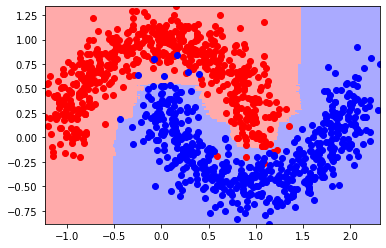

In [55]:
graph_boundary(random_forest_clf, class_one, class_two)